<a href="https://colab.research.google.com/github/YaninaK/sales-forecast/blob/main/notebooks/01_EDA_omissions_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales forecast for 20 stores for 31 days' period. 
## EDA omissions and clustering

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone -q https://github.com/YaninaK/sales-forecast.git
!pip install -r sales-forecast/requirements_Colab.txt -q 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 107.1 MB/s eta 0:00:00


In [3]:
%cd sales-forecast

/content/sales-forecast


In [4]:
import sys
import os

sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), "src", "sales_forecast"))

In [5]:
import random
import numpy as np
import pandas as pd
import missingno as msno
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from data.EDA_utilities import (
    get_missing_days_info, 
    get_distribution, 
    get_n_clusters, 
    plot_cluster_centroid
)
from data.make_dataset import load_data, get_dataset
from data.johnson_su_transformation import JohnsonSU
from data.impute_data import impute_with_medians, impute
from data.clean_data import clean_outliers

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
PATH = '/content/drive/MyDrive/ML_projects/01_Time_series/sales_forecast/'
DEFAULT_RANDOM_SEED = 3

In [8]:
def set_all_seeds(seed=DEFAULT_RANDOM_SEED):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)

set_all_seeds()

## 1. Data ingestion

In [9]:
train = load_data(PATH)
print(f'train.shape = {train.shape}')
train.head(2)

train.shape = (8230, 3)


,id,dt,target
0,0,2016-01-02,747.8
1,0,2016-01-03,681.2


In [10]:
test = pd.read_parquet(PATH + 'data/01_raw/test.parquet.gzip')
print(f'test.shape = {test.shape}')
test.tail(2)

test.shape = (540, 2)


,id,dt
538,19,2017-07-30
539,19,2017-07-31


In [11]:
sample_submit = pd.read_parquet(PATH + 'data/01_raw/sample_submit.parquet.gzip')
print(f'test.shape = {sample_submit.shape}')
sample_submit.head(2)

test.shape = (540, 3)


,id,dt,target
0,0,2017-07-01,500
1,0,2017-07-02,500


In [12]:
df = pd.concat([train, test], axis=0)
df['id'] = df['id'].astype('int8')
df['dt'] = pd.to_datetime(df['dt'])
df.dtypes

id                  int8
dt        datetime64[ns]
target           float64
dtype: object

In [13]:
n_shops = df['id'].nunique()
n_shops

20

## 2. EDA - date omissions.


### 2.1 Test

In [14]:
df_test = df[df['target'].isnull()]
test_days = pd.pivot_table(
    df_test, values='target', index=['dt'], columns=['id'], aggfunc=np.sum
).reset_index(level=-1)['dt'].tolist()

print(f'test period from {test_days[0].date()} till {test_days[-1].date()}')
print(f'output length = {len(test_days)}')

d0 = test_days[0].weekday()
d1 = test_days[-1].weekday()
print(f'prediction start and end weekdays: {d0, d1}')

test period from 2017-07-01 till 2017-07-31
output length = 27
prediction start and end weekdays: (5, 0)


In [15]:
test_calendar_days = pd.date_range(start=test_days[0], end=test_days[-1])
missing_test_days = [i for i in test_calendar_days if i not in test_days]
get_missing_days_info(missing_test_days)

Date omissions:

2017

July
 Wed: 2017-07-05 2017-07-12 2017-07-19 2017-07-26


### 2.2 Train


#### 2.2.1 Identify date omissions

In [16]:
df_train = df[~df['target'].isnull()]
data = pd.pivot_table(
    df_train, values='target', index=['dt'], columns=['id'], aggfunc=np.sum
    ).reset_index(level=-1)
data.columns = ['dt'] + list(range(n_shops))
data.set_index('dt', inplace=True)
calendar_days = pd.date_range(start=data.index[0], end=data.index[-1])

print(f'train data available from {data.index[0].date()} till {data.index[-1].date()}')
print(f'number of calendar days in observed period = {len(calendar_days)}')
print(f'number of available days of observation = {data.shape[0]}\n')

data.tail(2)

train data available from 2016-01-02 till 2017-06-30
number of calendar days in observed period = 546
number of available days of observation = 453



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
dt,,,,,,,,,,,,,,,,,,,,
2017-06-29,1039.9,717.1,820.9,721.0,453.5,630.8,944.2,847.9,1875.8,1169.7,840.1,786.9,1472.9,977.7,951.0,1204.2,829.0,915.1,1029.9,739.1
2017-06-30,1152.9,717.1,823.5,606.6,405.8,581.9,871.9,961.1,1798.1,935.4,860.9,742.2,1648.4,983.2,846.5,1128.9,783.5,859.9,961.5,629.7


In [17]:
missing_days = [i for i in calendar_days if not i in data.index]
get_missing_days_info(missing_days)

Date omissions:

2016

January
 Tue: 2016-01-05 2016-01-12 2016-01-19 2016-01-26

February
 Mon: 2016-02-29
 Tue: 2016-02-02 2016-02-09 2016-02-16 2016-02-23

March
 Wed: 2016-03-02 2016-03-09 2016-03-16 2016-03-23 2016-03-30

April
 Mon: 2016-04-18
 Wed: 2016-04-06 2016-04-13 2016-04-20 2016-04-27
 Thu: 2016-04-21

May
 Wed: 2016-05-04 2016-05-11 2016-05-18 2016-05-25
 Sun: 2016-05-01 2016-05-29

June
 Wed: 2016-06-01 2016-06-08 2016-06-15 2016-06-22 2016-06-29
 Thu: 2016-06-09

July
 Wed: 2016-07-06 2016-07-13 2016-07-20 2016-07-27

August
 Wed: 2016-08-03 2016-08-10 2016-08-17 2016-08-24 2016-08-31

September
 Wed: 2016-09-07 2016-09-14 2016-09-21 2016-09-28

October
 Mon: 2016-10-03
 Wed: 2016-10-05 2016-10-12 2016-10-19 2016-10-26

November
 Wed: 2016-11-02 2016-11-09 2016-11-16 2016-11-23 2016-11-30

December
 Mon: 2016-12-26
 Wed: 2016-12-07 2016-12-14 2016-12-21 2016-12-28
 Sun: 2016-12-25

2017

January
 Wed: 2017-01-04 2017-01-11 2017-01-18 2017-01-25
 Sun: 2017-01-01

Februa

__Findings:__ In Jan and Feb 2016 days-off were on Tuesdays. Then they switched to Wednesdays

    Add missing dates
    Switch Jan and Feb 2016 days-off from Tuesdays to Wednesdays
    Drop days-off
    Impute data in missing dates with medians for particular year-month-weekday

In [18]:
data = get_dataset(train)
data.shape

(468, 20)

#### 2.2.3 Identify value omissions for particular shops

##### Matrix

Nullity matrix lets us quickly visually pick out patterns in data completion.

From the diagram below we can see the time periods with missing data for each of the 20 shops

The sparkline at right summarizes the general shape of the data completeness and points out the rows with the maximum and minimum nullity in the dataset.

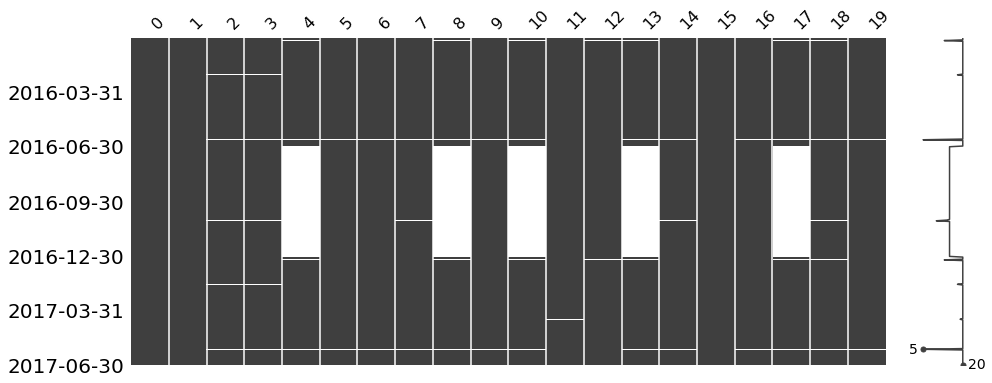

In [19]:
msno.matrix(data.set_index(data.index), freq='BQ', figsize=(15, 6));

##### Bar



The bar diagram shows the data available for each shop in both absolte and relative terms.

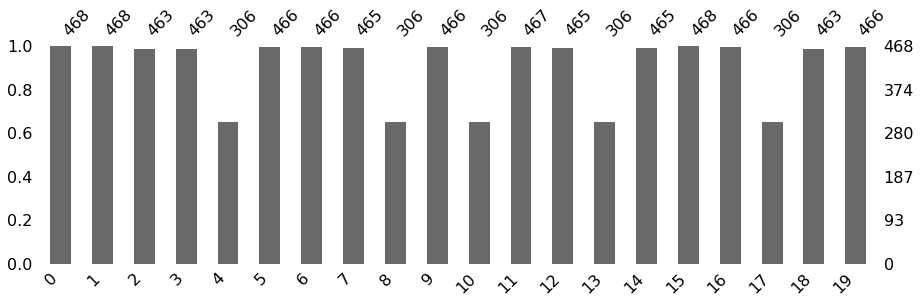

In [20]:
msno.bar(data, figsize=(15, 4));

##### Heatmap

Correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another.

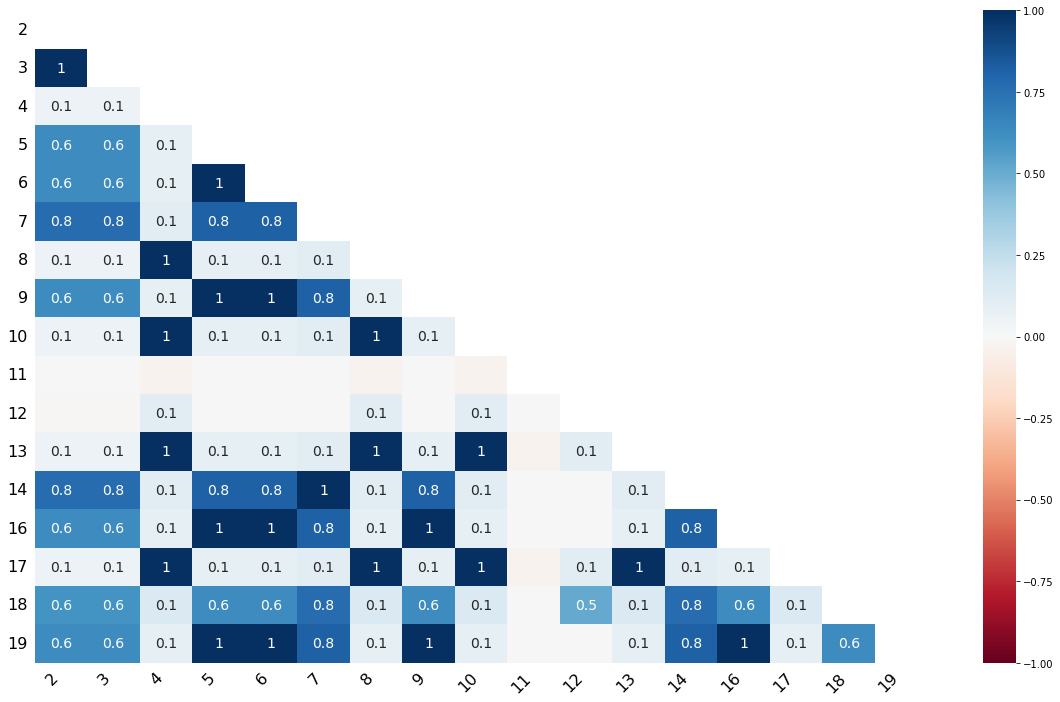

In [21]:
msno.heatmap(data);

##### Dendrogram


The dendrogram reveals trends deeper than the pairwise ones visible in the correlation heatmap above.

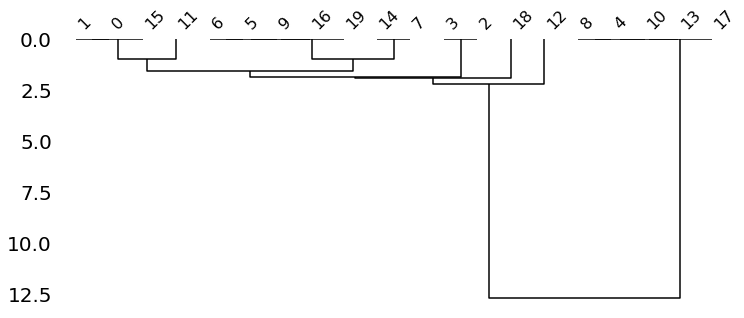

In [22]:
msno.dendrogram(data, figsize=(12, 5));

__Shops 4, 8, 10, 13, 17:__ 

In [23]:
list_1 = [4, 8, 10, 13, 17]
ind_1 = data.index[data[list_1[0]].isnull().values]
print(*[ind_1[i].date() for i in [0, 1, 2, -3, -2, -1]])

2016-01-05 2016-06-19 2016-07-01 2016-12-31 2017-01-06 2017-06-04



* data for 2 quaters from 2016-07-01 till 2016-12-31 is missing
* the other dates with missing data: 
  * 2016: Jan 6, Jun 19
  * 2017: Jan 6, Jun 4

__Shops 2, 3:__

In [24]:
shop = 2
data.index[data[shop].isnull().values]

DatetimeIndex(['2016-03-03', '2016-06-19', '2016-11-01', '2017-02-16',
               '2017-06-04'],
              dtype='datetime64[ns]', name='dt', freq=None)


* the dates with missing data: 
  * 2016: Mar 3, Jun 19, Nov 1
  * 2017: Feb 16, Jun 4


__Shop 18:__

In [25]:
shop = 18
data.index[data[shop].isnull().values]

DatetimeIndex(['2016-01-05', '2016-06-19', '2016-11-01', '2017-01-06',
               '2017-06-04'],
              dtype='datetime64[ns]', name='dt', freq=None)


* the dates with missing data: 
  * 2016: Jan 6, Jun 19, Nov 1
  * 2017: Jan 6, Jun 4

__Shops 7, 14:__

In [26]:
shop = 7
data.index[data[shop].isnull().values]

DatetimeIndex(['2016-06-19', '2016-11-01', '2017-06-04'], dtype='datetime64[ns]', name='dt', freq=None)


* the dates with missing data: 
  * 2016: Jun 19, Nov 1
  * 2017: Jun 4

__Shop 12:__

In [27]:
shop = 12
data.index[data[shop].isnull().values]

DatetimeIndex(['2016-01-05', '2016-10-31', '2017-01-06'], dtype='datetime64[ns]', name='dt', freq=None)


* the dates with missing data: 
  * 2016: Jan 6, Oct 31
  * 2017: Jan 6

__Shops 5, 6, 9, 16, 19:__

In [28]:
shop = 5
data.index[data[shop].isnull().values]

DatetimeIndex(['2016-06-19', '2017-06-04'], dtype='datetime64[ns]', name='dt', freq=None)


* the dates with missing data: 
  * 2016: Jun 19
  * 2017: Jun 4

__Shops 11:__

In [29]:
shop = 11
data.index[data[shop].isnull().values]

DatetimeIndex(['2017-04-15'], dtype='datetime64[ns]', name='dt', freq=None)


* the dates with missing data:  
  * 2017: Apr 15

### 2.3 Time series cluster analysis

1st half 2017

In [30]:
ts = data[-155:].ffill().bfill()
ts.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
dt,,,,,,,,,,,,,,,,,,,,
2017-01-01,817.65,501.7,606.35,378.8,395.9,444.6,607.45,572.25,1473.5,710.05,655.75,500.1,931.7,644.0,602.35,734.75,440.55,497.45,698.55,431.05
2017-01-02,755.80,481.3,570.50,467.4,328.7,437.7,613.40,641.70,2086.8,777.60,602.40,502.4,689.8,840.1,505.00,815.60,353.60,378.00,592.90,408.30


#### 2.3.1 Distribution analysis

Shop 0


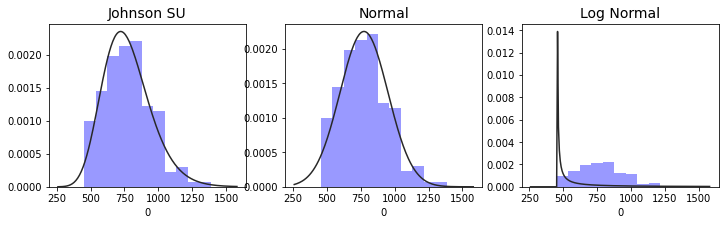

Shop 1


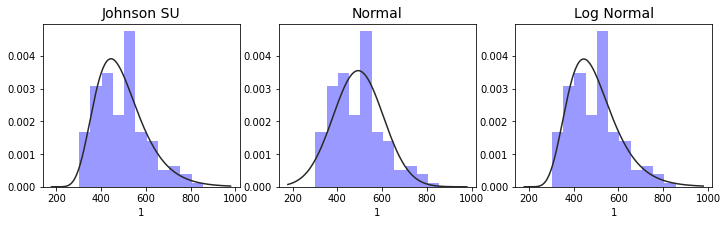

Shop 2


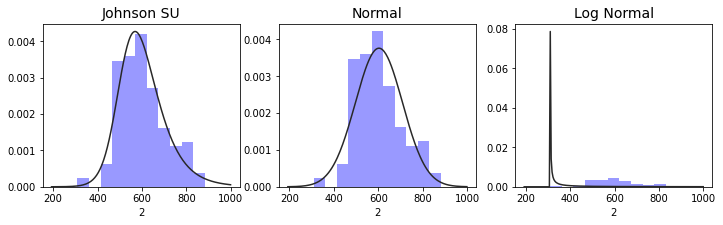

Shop 3


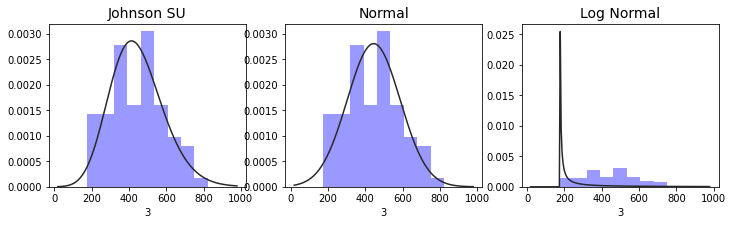

Shop 4


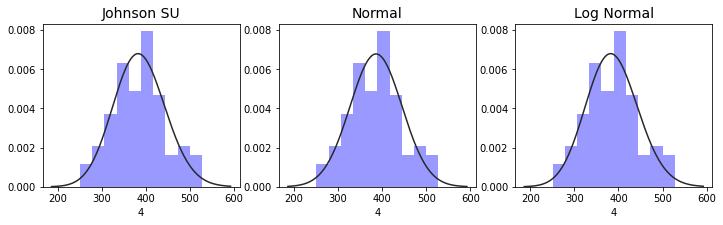

Shop 5


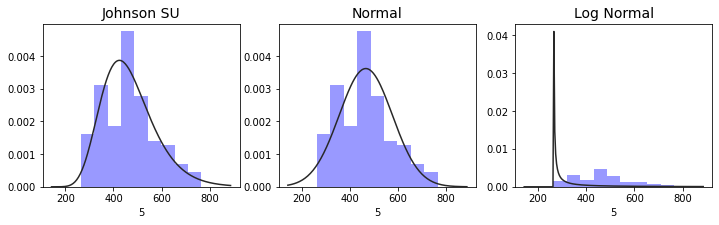

Shop 6


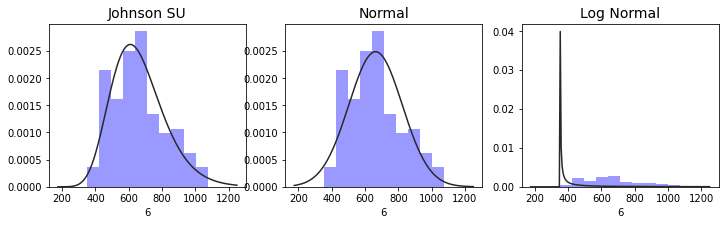

Shop 7


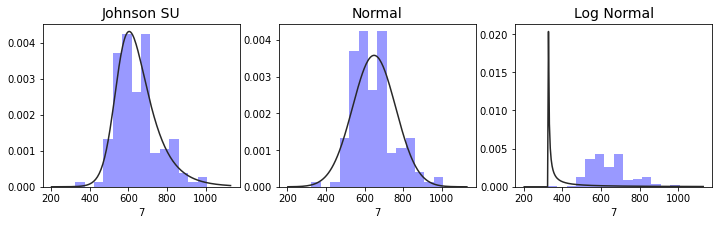

Shop 8


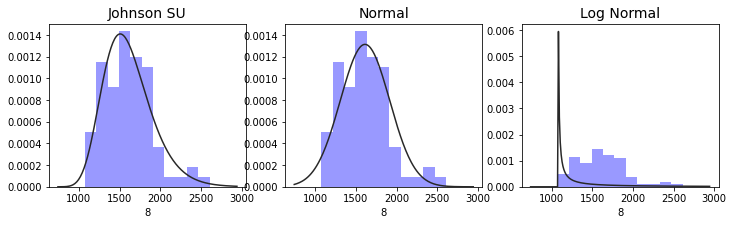

Shop 9


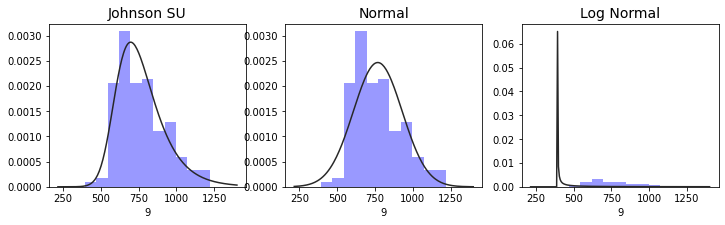

Shop 10


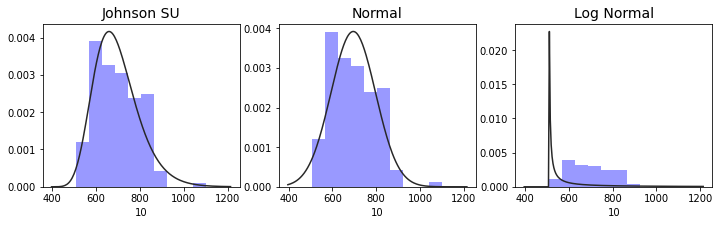

Shop 11


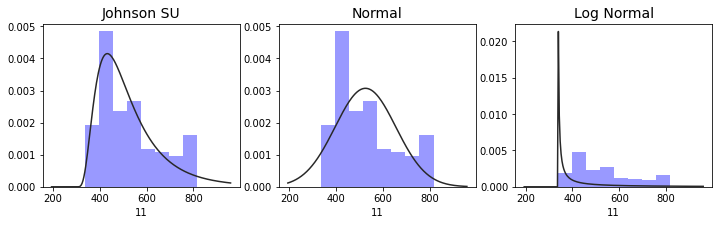

Shop 12


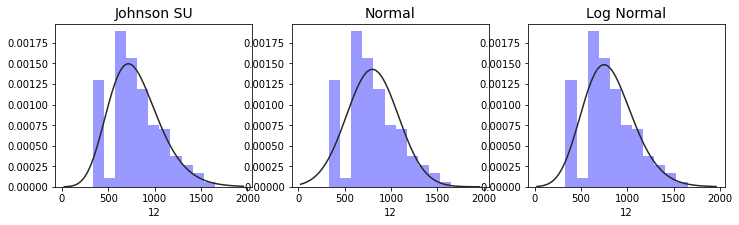

Shop 13


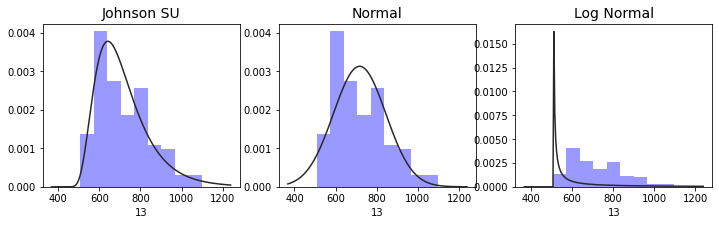

Shop 14


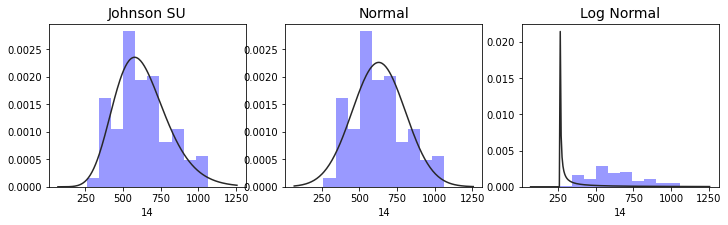

Shop 15


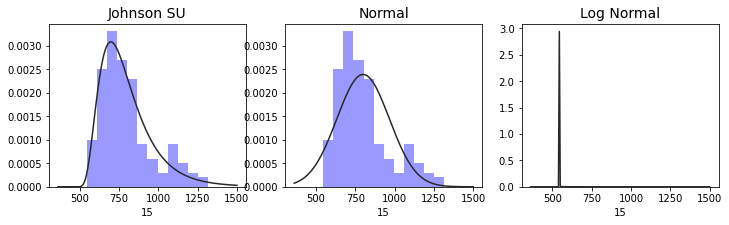

Shop 16


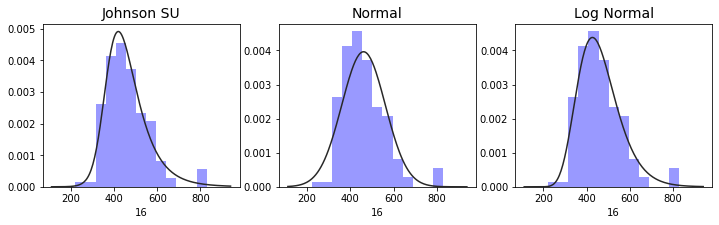

Shop 17


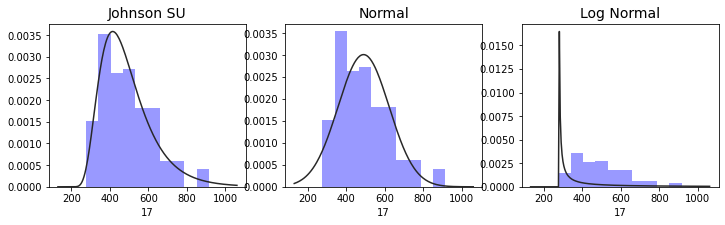

Shop 18


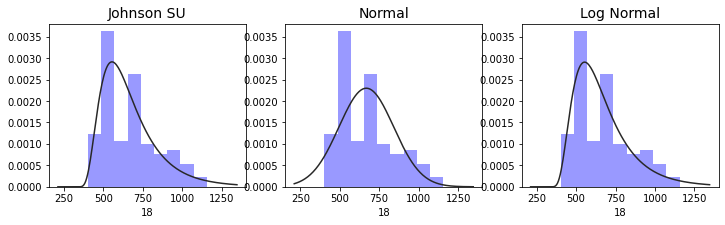

Shop 19


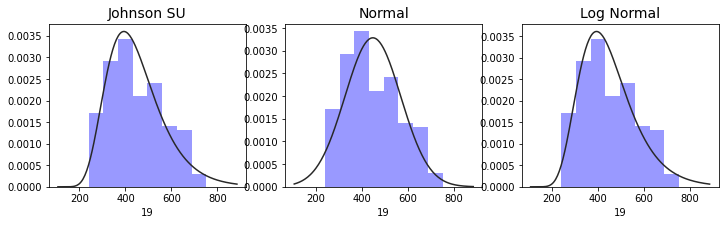

In [31]:
for shop in range(n_shops):
  print(f'Shop {shop}')
  get_distribution(ts, shop)

__Findings:__ The variable is not normally distributed. The closest approximation is Johnson SU distribution.

#### 2.3.2 Johnson SU transformation

In [32]:
scaler = JohnsonSU()
scaler.fit(ts)
ts_scaled = scaler.transform(ts)

ts_scaled.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
dt,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.343048,0.229533,0.162004,-0.401177,0.184603,-0.070055,-0.242648,-0.675473,-0.370675,-0.224663,-0.281299,0.087692,0.557592,-0.428592,-0.047691,-0.195432,-0.052330,0.260832,0.413795,0.019125
2017-01-02,-0.002177,0.046771,-0.212059,0.234807,-0.977234,-0.136523,-0.202622,0.101396,1.460332,0.233240,-0.905511,0.106570,-0.306760,1.014866,-0.650773,0.337818,-1.266476,-0.834970,-0.223827,-0.181016


#### 2.3.3 Clean outliers

In [33]:
ts_scaled = clean_outliers(ts_scaled)

Number of outliers = 7


#### 2.3.4 Select the number of clusters

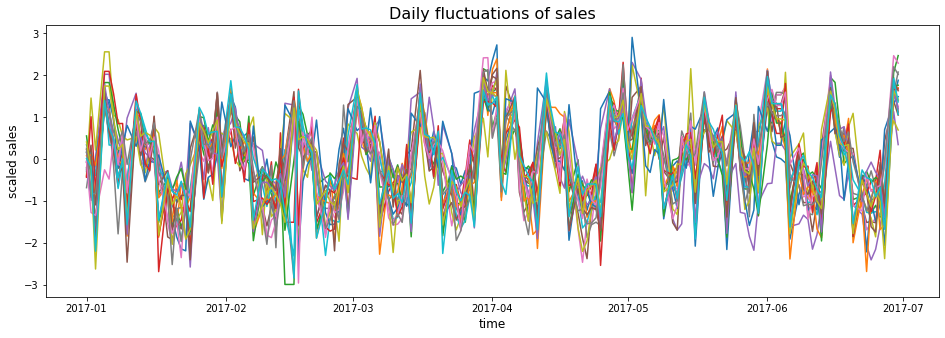

In [34]:
plt.figure(figsize=(16, 5))
plt.plot(ts_scaled)
plt.title('Daily fluctuations of sales', fontsize=16)
plt.xlabel('time', fontsize=12)
plt.ylabel('scaled sales', fontsize=12);

##### Basic KMeans

100%|██████████| 8/8 [00:02<00:00,  3.75it/s]


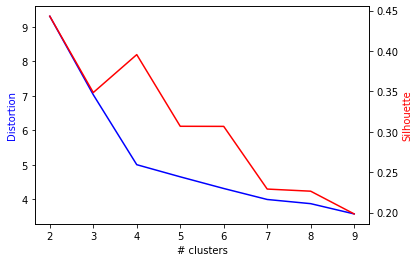

In [35]:
get_n_clusters(ts_scaled, metric="euclidean", random_state=DEFAULT_RANDOM_SEED)

##### DTW

100%|██████████| 8/8 [01:43<00:00, 12.98s/it]


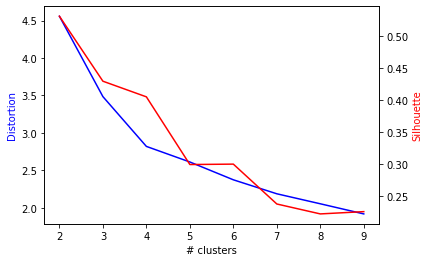

In [36]:
get_n_clusters(ts_scaled, metric="dtw", random_state=DEFAULT_RANDOM_SEED)

#### 2.3.5 Cluster analysis

cluster_0:  [4, 10]
cluster_1:  [0, 1, 3, 11, 12, 13, 14, 15, 18, 19]
cluster_2:  [8]
cluster_3:  [5, 6, 17]
cluster_4:  [2, 7, 9, 16]


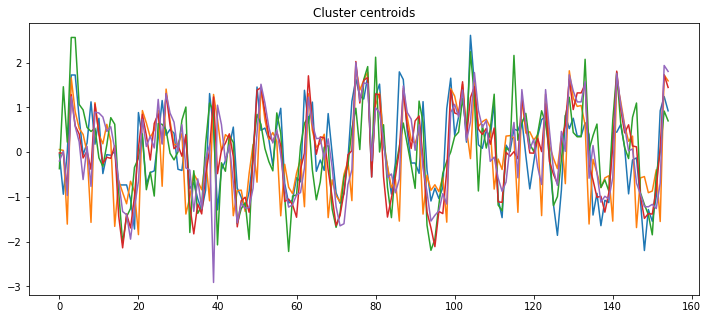

In [37]:
n_clusters = 5
ts_dtw = TimeSeriesKMeans(
    n_clusters=n_clusters, 
    metric="dtw", 
    n_jobs=6, 
    max_iter=10, 
    random_state=DEFAULT_RANDOM_SEED
)
ts_dtw.fit(ts_scaled.T)

clusters = pd.DataFrame(data=ts_dtw.labels_, index=range(n_shops), columns=['cluster'])
for i in range(n_clusters):
  print(f'cluster_{i}: ',
      clusters[clusters['cluster']==i].index.tolist()
  )
plot_cluster_centroid(ts_dtw, n_clusters)

__Findings:__

* Shops 4, 8, 10, which have no data for the 2nd part of 2016, form unique clusters. So, we can't apply linear regression with other shops values to handle missing data. 

* Thus, time series for the 2nd part of 2016 could not be used due to lack of data for the shops 4, 8, 10, 13, 17.  

__Cluster 1__

In [38]:
correlated_shops = {
    3: [0, 1, 15, 19],
    11: [0, 1, 3, 15, 19],
    12: [0, 1, 3, 11, 15, 19],
    14: [0, 1, 3, 11, 12, 15, 19],
    18: [0, 1, 3, 11, 12, 14, 15, 19],    
}

__Cluster 4__

In [39]:
correlated_shops = {2: [7, 9, 16]}

## 3. Descriptive statistics

In [40]:
data = impute(data)

In [41]:
stats = data.astype('float32').describe().T
round(stats, 1)

,count,mean,std,min,25%,50%,75%,max
0,468.0,779.6,192.2,370.2,630.5,759.2,897.9,1385.5
1,468.0,487.4,123.4,263.3,396.3,474.0,551.2,1021.9
2,468.0,595.5,107.9,306.6,511.9,579.6,667.8,909.4
3,468.0,437.0,148.2,174.3,325.1,423.0,538.4,870.5
4,310.0,385.8,54.4,250.8,348.2,380.6,421.3,545.2
5,468.0,454.8,108.5,223.5,367.2,448.9,520.0,920.4
6,468.0,642.6,166.8,350.7,515.3,623.2,737.9,1209.0
7,468.0,634.8,114.3,324.6,548.1,615.4,708.4,1007.5
8,310.0,1547.7,293.1,985.5,1326.7,1534.4,1727.2,2680.7
9,468.0,781.7,184.2,393.4,638.9,748.4,884.5,1568.6


In [42]:
stats[stats['count'] < data.shape[0]]

,count,mean,std,min,25%,50%,75%,max
4,310.0,385.820953,54.366192,250.800003,348.200012,380.600006,421.274994,545.200012
8,310.0,1547.686646,293.129150,985.500000,1326.724976,1534.350098,1727.199951,2680.699951
10,310.0,675.897705,103.153671,449.299988,594.275024,669.150024,755.625000,1102.099976
13,310.0,688.950500,127.386917,401.899994,587.774963,661.900024,781.799988,1098.099976
17,310.0,485.493866,147.372940,276.500000,366.049988,459.650024,556.049988,1191.699951


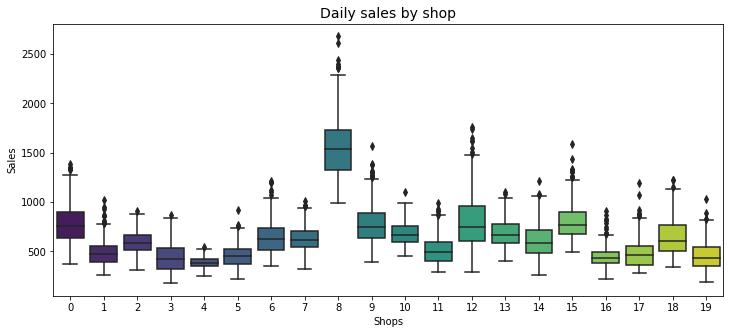

In [43]:
plt.figure(figsize=(12, 5))
plt.title('Daily sales by shop', size=14)
plt.xlabel('Shops')
plt.ylabel('Sales')
sns.boxplot(data=data, palette="viridis");

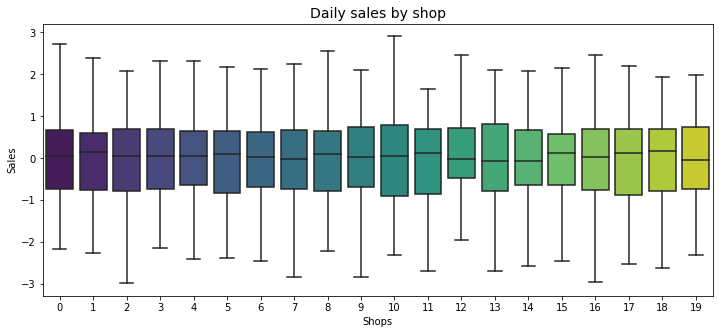

In [44]:
plt.figure(figsize=(12, 5))
plt.title('Daily sales by shop', size=14)
plt.xlabel('Shops')
plt.ylabel('Sales')
sns.boxplot(data=ts_scaled, palette="viridis");